In [1]:
import glob
import joblib

In [2]:
from utils import convert_episodes_to_traj_class

In [3]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

In [4]:
from decision_bias_analysis_tools import ComputeFourBiasClips2
from parameters import EXPLORE, HOME_NODE, UnrewNamesSub, RewNames
import evaluation_metrics as em

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.size"] = 18

In [8]:
figpath = '/Users/us3519/mouse-maze/figs/paper figs/figure_results_rewarded'
os.makedirs(figpath)

In [39]:
def load(model_name):
    
    if model_name == 'RewAnimals':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in RewNames]
        return tfs

    if model_name == 'BiasedWalk4':
        tfs = [LoadTrajFromPath(f'../../../newrosenberg/outdata/{_}-RW5-tf') for _ in RewNames]
        return tfs
    
#     if model_name == 'RandomWalk':
#         tfs = [LoadTrajFromPath('../outdata/rw01-tf')]
#         return tfs
    
#     if model_name == 'MarkovChain':
#         tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in UnrewNamesSub]
#         return tfs

    tfs = []
    for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=50000/**/episodes_*.pkl'):
        s = joblib.load(f)
        tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
        tfs.append(tf)
    return tfs

In [40]:
def get_biases(tfs):
    bi = np.array([ComputeFourBiasClips2(tf,ma,SplitModeClips(tf,ma),mode=EXPLORE)[0] for tf in tfs]) # bias using exploration only
    return bi

In [11]:
ma=NewMaze()

In [41]:
bi_altoptions = get_biases(load('TeAltOptions'))

In [42]:
bi_biasedwalk = get_biases(load('BiasedWalk4'))

In [15]:
# bi_markov = get_biases(load('MarkovChain'))

In [44]:
bi_animals = get_biases(load('RewAnimals'))

In [45]:
bi_randomwalk = np.array([[2/3, 1/2, 2/3, 1/2]])

In [129]:
from matplotlib.cm import get_cmap

cmap = get_cmap('Reds')
# red1 = cmap(0.4)  # lighter
# red2 = cmap(0.8)  # darker

model_colors = {
    'RewAnimals': cmap(0.3),
    'TeAltOptions': 'g',
    'BiasedWalk4': 'y',
#     'Uncertainty': 'tab:pink',       # no RL model for rewarded yet
    'RandomWalk': 'b',
#     'MarkovChain': 'k',
#     'Optimal': 'k:',
}

labels = {
    'RewAnimals':   'RewAnimals',
    'TeAltOptions': '$\epsilon$$z$-Greedy',
    'BiasedWalk4':  'Biased Walk',
    'Uncertainty':  'Uncertainty',
    'RandomWalk':   'random',
    'Optimal':      'optimal',
}

/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_30282/3673000718.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Reds')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


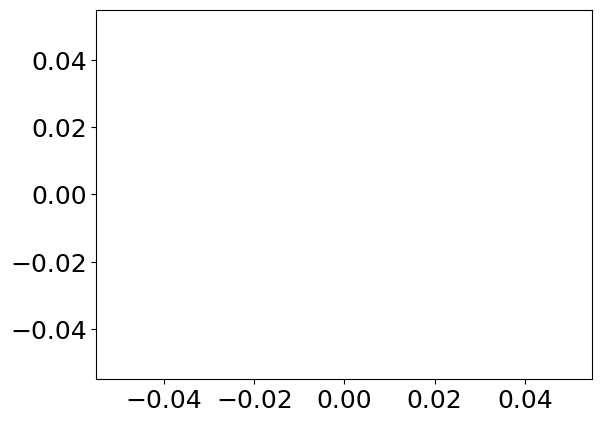

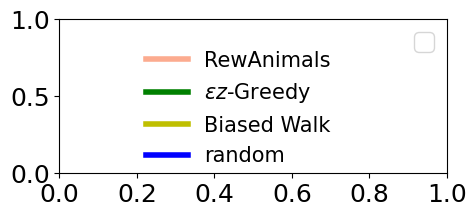

In [130]:
# reate a dummy plot to get legend handles
fig, ax = plt.subplots()
lines = []

for model_name in model_colors:
    lines.append(ax.plot([], [], c=model_colors[model_name], linewidth=4, label=labels[model_name])[0])

fig_legend = plt.figure(figsize=(5, 2))
fig_legend.legend(handles=lines, labels=[line.get_label() for line in lines], fontsize='small', loc='center', frameon=False)
fig_legend.tight_layout()
fig_legend.savefig(f'{figpath}/legend_only.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.legend()
plt.show()  # it saves the correct legend but does not show in jupyter notebook

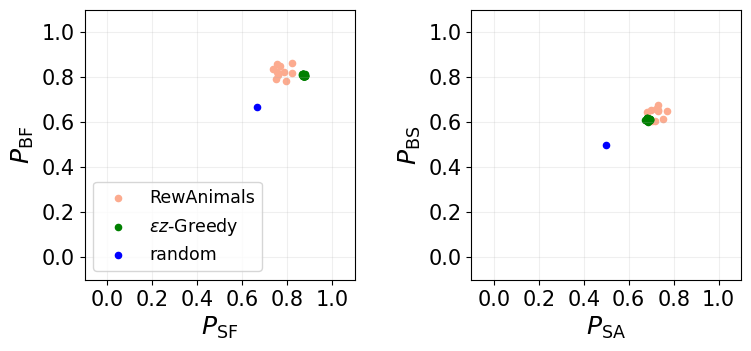

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.8))

s = 20
alpha = 1
ax[0].scatter(bi_animals[:,0], bi_animals[:,2], color=model_colors["RewAnimals"], label=labels['RewAnimals'], s=s, alpha=alpha,)
ax[0].scatter(bi_altoptions[:,0], bi_altoptions[:,2], c=model_colors["TeAltOptions"], label=labels['TeAltOptions'], s=s, alpha=alpha,)
ax[0].scatter(bi_randomwalk[:,0], bi_randomwalk[:,2], c=model_colors["RandomWalk"], label=labels['RandomWalk'], s=s, alpha=1,)

ax[1].scatter(bi_animals[:,1], bi_animals[:,3], color=model_colors["RewAnimals"], label=labels['RewAnimals'], s=s, alpha=alpha,)
ax[1].scatter(bi_altoptions[:,1], bi_altoptions[:,3], c=model_colors["TeAltOptions"], label=labels['TeAltOptions'], s=s, alpha=alpha,)
ax[1].scatter(bi_randomwalk[:,1], bi_randomwalk[:,3], c=model_colors["RandomWalk"], label=labels['RandomWalk'], s=s, alpha=1,)


for _ in ax:
    _.tick_params(axis='both', labelsize='small')
    _.set_aspect('equal')
    _.set_xlim([-0.1,1.1])
    _.set_ylim([-0.1,1.1])
    _.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    _.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    _.grid(alpha=0.2)

ax[0].legend(loc='lower left', fontsize='x-small') 
# ax[1].legend(loc='lower left', fontsize='x-small') 
ax[0].set_xlabel('$P_{\mathrm{SF}}$', fontsize='medium')
ax[0].set_ylabel('$P_{\mathrm{BF}}$', fontsize='medium')
ax[1].set_xlabel('$P_{\mathrm{SA}}$', fontsize='medium')
ax[1].set_ylabel('$P_{\mathrm{BS}}$', fontsize='medium')


plt.tight_layout()
plt.savefig(f'{figpath}/decisionbiases.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [49]:
def get_expeff(tfs, le=6):
    y_tfs = []
    for tf in tfs:
        wcn=NewNodesMerge3(tf,ma,le) 
        x=wcn[1]
        y=wcn[2]
        y_tfs.append(y)

    min_len = min(len(_) for _ in y_tfs)
    y_tfs = np.array([_[:min_len] for _ in y_tfs])  # some tfs might not have all window sizes
    y_mu = np.mean(y_tfs, axis=0)
    y_std = np.std(y_tfs, axis=0)
    return x[:min_len], y_tfs, y_mu, y_std

In [50]:
def get_ee(le):
    ee_dict = {}
    for model_name in model_colors:
        print(model_name)
        if model_name in ['MarkovChain', 'Optimal']:
            continue
        tfs = load(model_name)[:30]
        print("len(tfs)", len(tfs))
        ee_dict[model_name] = get_expeff(tfs, le=le)
    return ee_dict

In [117]:
def plot_ee(exp_eff_dict, le, figsize=(8, 4), axhline=32, xlim=(2, 2*(10**3)), ylim=(0, 2**6+2), labelpad=10):
    x_dfs=list(range(1, (2**le)+1))
    y_dfs=list(range(1, (2**le)+1))

    plt.figure(figsize=figsize)
    ax = plt.gca()

    for model_name in model_colors:
        print(model_name)
        if model_name in ['MarkovChain', 'Optimal', 'Uncertainty']:
            continue
        x, _, y_mu, y_std = exp_eff_dict[model_name]
        linewidth = 3 if model_name == 'RewAnimals' else 1
        alpha = 1
        label = labels[model_name]
        if model_name == 'RandomWalk':
            linewidth = 0.5
            alpha = 0.8
        plt.plot(x, y_mu, c=model_colors[model_name], linestyle='-',linewidth=linewidth, label=label, alpha=alpha)
        if model_name != 'RandomWalk':
            ax.fill_between(x, y_mu+y_std, y_mu-y_std, color=model_colors[model_name], alpha=0.2)

    plt.plot(x_dfs,y_dfs,'k',linewidth=0.7, alpha=0.4, label='optimal')

    plt.axhline(axhline, ls=':', c='k', lw=1)
    # plt.axhline(2**(le), ls=':', c='k')
    plt.legend(loc='lower right', fontsize='x-small')
    ax.tick_params(axis='both', labelsize='small')
    ax.set_xlabel(f'Nodes visited (Level {le})', fontsize='medium')
    ax.set_ylabel(f'New nodes found\n(Level {le})', fontsize='medium', labelpad=labelpad)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig(f'{figpath}/expeff_le={le}.pdf', dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

RewAnimals
TeAltOptions
BiasedWalk4
RandomWalk


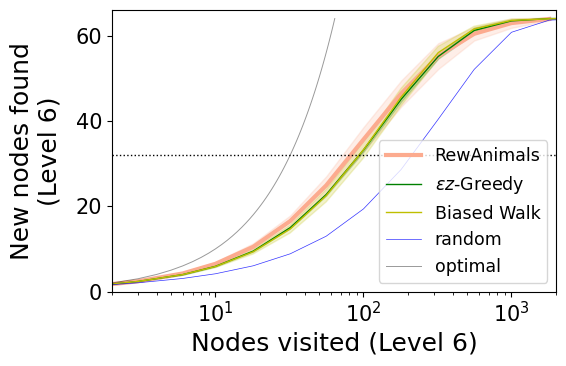

In [132]:
# exp_eff_dict6 = get_ee(6)
plot_ee(exp_eff_dict6, 6, figsize=(6, 4))

RewAnimals
TeAltOptions
BiasedWalk4
RandomWalk


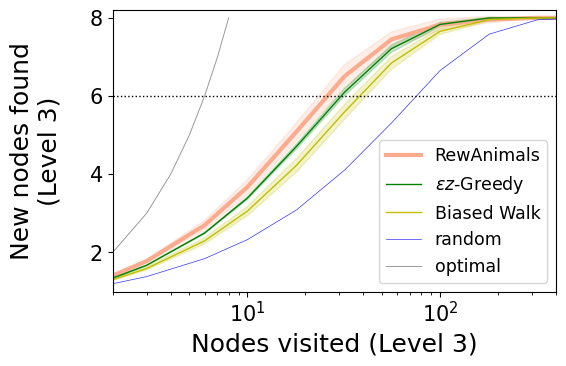

In [133]:
# exp_eff_dict3 = get_ee(3)
plot_ee(exp_eff_dict3, 3, figsize=(6, 4), axhline=6, xlim=(2, 400), ylim=(1, 2**3+0.2), labelpad=20)

RewAnimals
TeAltOptions
BiasedWalk4
RandomWalk


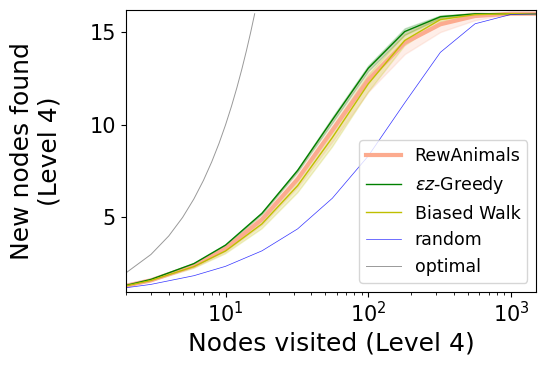

In [134]:
# exp_eff_dict4 = get_ee(4)
plot_ee(exp_eff_dict4, 4, figsize=(6, 4), xlim=(2, 1500), ylim=(1, 2**4+0.2), labelpad=20)

RewAnimals
TeAltOptions
BiasedWalk4
RandomWalk


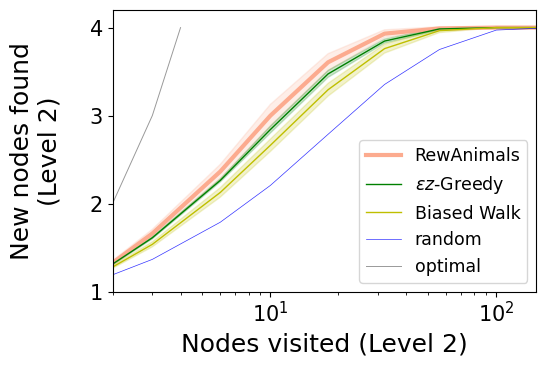

In [135]:
# exp_eff_dict2 = get_ee(2)
plot_ee(exp_eff_dict2, 2, figsize=(6, 4), xlim=(2, 150), ylim=(1, 2**2+0.2), labelpad=20)

In [56]:
import parameters as p

In [57]:
def animal_oi():
    # Compute distribution of end nodes visited for the 4-bias random walks
    le=6
    ln=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le
    k=len(p.RewNames)
    Viw=[];Enw=[];Nuw=[]
    for nickname in p.RewNames+p.UnrewNamesSub:
        tf=LoadTrajFromPath('../../../newrosenberg/outdata/' + nickname+'-RW5-tf')
        cl=SplitModeClips(tf,ma) # find the clips
        ce=cl[np.where(cl[:,3]==p.EXPLORE)] # clips of exploration
        ne=np.concatenate([tf.no[c[0]][c[1]:c[1]+c[2],0] for c in ce]) # nodes excluding the last state in each clip
        ns=ne[np.isin(ne,ln)]
        _,Vis,_,_=hist(ns,xlabel='End node',ylabel='Number of visits',
            loc='upper left',bins=np.arange(2**le-1,2**(le+1))-0.5,xlim=[62.5,126.5])
        Num=np.sum(Vis)
        Ent=Entropy(Vis)
        Viw+=[np.array(Vis)]
        Enw+=[Ent]
        Nuw+=[Num]
#         print(nickname)
#         print('Nodes:   {:5.0f}'.format(Num))
#         print('Entropy: {:4.3f}'.format(Ent))
#         plt.show()
        plt.close()
    Viw=np.array(Viw)
    Enw=np.array(Enw)
    Nuw=np.array(Nuw)
    return Viw

In [58]:
Viw = animal_oi()
Vuw = Viw[:len(p.RewNames)]

Viw.shape, Vuw.shape

((19, 64), (10, 64))

In [60]:
inner=np.array([75,76,77,78,87,88,89,90,99,100,101,102,111,112,113,114])-63
outer=np.array([63,65,71,73,95,97,103,105,106,109,110,121,122,125,126,124,94,92,86,84,83,80,79,68,67,64])-63


In [61]:
def get_oiratio(tfs):
    return [em.outside_inside_ratio(tf, re=False) for tf in tfs]

In [62]:
def get_oi():
    oi_dict = {}
    for model_name in model_colors:
        print(model_name)
        if model_name in ['MarkovChain', 'Optimal']:
            continue
        else:
            tfs = load(model_name)[:30]
            print("len(tfs)", len(tfs))
            oi_dict[model_name] = get_oiratio(tfs)
    return oi_dict

In [63]:
oi_ratios_dict = get_oi()

RewAnimals
len(tfs) 10
TeAltOptions
len(tfs) 30
BiasedWalk4
len(tfs) 10
Uncertainty
len(tfs) 30
RandomWalk
len(tfs) 20


In [97]:
del oi_ratios_dict['RandomWalk']
del oi_ratios_dict['Uncertainty']

In [65]:
oi_ratios_dict.keys()

dict_keys(['RewAnimals', 'TeAltOptions', 'BiasedWalk4', 'Uncertainty'])

In [66]:
from scipy.stats import sem

RewAnimals
mean_ratio 2.5462963326274375
TeAltOptions
mean_ratio 2.5708173766265716
BiasedWalk4
mean_ratio 2.120160735597185


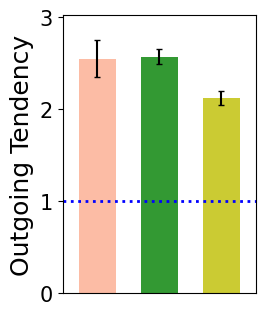

In [136]:
plt.figure(figsize=(3, 3.5))
ax = plt.gca()

for i, model_name in enumerate(oi_ratios_dict):
    print(model_name)
    ratios = oi_ratios_dict[model_name][:10]
    jitter = np.random.uniform(-0.05, 0.05, size=len(ratios))
#     plt.plot(i+jitter, ratios, c=model_colors[model_name], marker='.', linestyle='none', markersize=10, alpha=1, label=model_name)
    mean_ratio = np.mean(ratios)
    print("mean_ratio", mean_ratio)
    plt.bar(i/2, mean_ratio, yerr=sem(ratios), color=model_colors[model_name], width=0.3, capsize=2, alpha=0.8, label=labels[model_name])

plt.axhline(1, ls=':', c=model_colors['RandomWalk'], lw=2, label=labels['RandomWalk'])
plt.xticks([])
ax.tick_params(axis='both', labelsize='small')
plt.ylabel('Outgoing Tendency', fontsize='medium')
# plt.legend(loc='upper right', fontsize='x-small')
plt.margins(0.1)
plt.tight_layout()
plt.savefig(f'{figpath}/oiratio.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [68]:
from collections import defaultdict

In [70]:
def get_firstnode(tfs):
    dicts = [em.first_endnode_label(tf) for tf in tfs]
    merged = defaultdict(list)
    for d in dicts:
        for k, v in d.items():
            merged[k].append(v)
    return merged

def get_firstnode_dict():
    firstnode_dict = {}
    for model_name in model_colors:
        print(model_name)
        if model_name in ['MarkovChain', 'Optimal']:
            continue
        elif model_name in ['RewAnimals']:
            with open(p.OUTDATA_PATH + 'first_endnode_label_rewarded.pkl', 'rb') as f:
                first_endnode_label_animal = pickle.load(f)
            firstnode_dict[model_name] = first_endnode_label_animal
        else:
            tfs = load(model_name)[:10]
            print("len(tfs)", len(tfs))
            firstnode_dict[model_name] = get_firstnode(tfs)
    return firstnode_dict

In [99]:
firstnode_dict = get_firstnode_dict()
del firstnode_dict['RandomWalk']
del firstnode_dict['Uncertainty']

In [72]:
import matplotlib.ticker as mtick

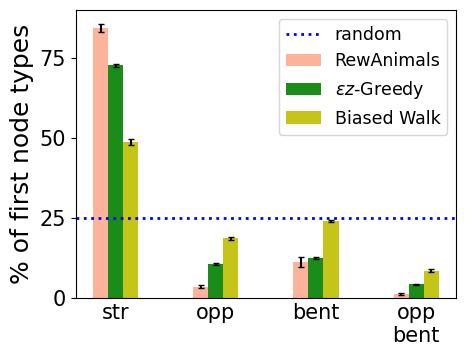

In [137]:
import matplotlib.image as mpimg
from scipy.stats import sem


fig = plt.figure(figsize=(5, 3.9))
ax = plt.gca()

for m, model_name in enumerate(firstnode_dict):
    values_dict = firstnode_dict[model_name]
    new_values_dict = {'str': values_dict['straight'], 'opp': values_dict['opposite straight'], 'bent': values_dict['bent straight'], 'opp\nbent': values_dict['opposite bent straight']}
    for i, t in enumerate(new_values_dict):
        data = np.array(new_values_dict[t])
#         print(m, i, data, f'{round(np.mean(data), 3)}\% \pm {round(sem(data), 3)}\%')
        plt.bar(i+m*0.15, np.mean(data), color=model_colors[model_name], yerr=sem(data), 
               label=labels[model_name] if i == 0 else '', capsize=2, width=0.15, alpha=0.9)

plt.axhline(25, c=model_colors['RandomWalk'], ls=':', lw=2, label=labels['RandomWalk'])

ax.legend(fontsize='x-small')
ax.set_ylabel('% of first node types', fontsize='medium')
ax.set_yticks([0, 25, 50, 75])
ax.set_xticks(np.arange(len(new_values_dict))+0.15, list(new_values_dict.keys()))
ax.tick_params(axis='x', labelsize='small', length=0)
ax.tick_params(axis='y', labelsize='small')
plt.tight_layout()

plt.savefig(f'{figpath}/firstnodeall.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [74]:
RewNames

['B1', 'B2', 'B3', 'B4', 'C1', 'C3', 'C6', 'C7', 'C8', 'C9']

In [140]:
model_colors['mouse B1'] = model_colors['RewAnimals']
model_colors['mouse C1'] = model_colors['RewAnimals']

In [81]:
def nodebias(tr, ma):
    tu = TallyNodeStepTypes(tr,ma)
    n = 2**ma.le-1 # number of nodes below end node level
    bl = tu[:n,0]/(tu[:n,0]+tu[:n,1]) # inleft/(inleft+inright)
    sl = np.sqrt(tu[:n,0]*tu[:n,1]/(tu[:n,0]+tu[:n,1])**3) # std dev
    return bl, sl

def get_nodebias_dict(model_names):
    nodebias_d = {}
    for model_name in model_names:
        print(model_name)
        if model_name in ['MarkovChain', 'Optimal', 'RandomWalk', 'Animals']:
            continue
        elif model_name in ['mouse B1']:
            bl, sl = nodebias(LoadTrajFromPath('../outdata/B1-tf'), ma)
        elif model_name in ['mouse C1']:
            bl, sl = nodebias(LoadTrajFromPath('../outdata/C1-tf'), ma)
        else:
            tf = load(model_name)[0]
            bl, sl = nodebias(tf, ma)
        nodebias_d[model_name] = (bl, sl)
    return nodebias_d

In [126]:
def plot_percent_turns(model_names, filename):

    plt.figure(figsize=(10, 4))
    for m in model_names:
        bl, sl = nodebias_dict[m]
        plt.errorbar(range(len(bl)), bl, yerr=sl, c=model_colors[m], linewidth=1.5, label=labels.get(m, m))

    plt.axhline(0.5, lw=1.5, ls=':', c=model_colors['RandomWalk'], label=labels['RandomWalk'])
    plt.title('Spatial distribution of left-right bias', fontsize='medium')
    plt.legend(loc='lower left', fontsize='x-small')
    plt.xlabel('Node', fontsize='medium')
    plt.ylabel('left/(left+right)', fontsize='medium')
    plt.tick_params(axis='both', labelsize='small')
    plt.grid(alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    plt.savefig(f'{figpath}/{filename}', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    return

In [83]:
nodebias_dict = get_nodebias_dict(model_colors)

RewAnimals
TeAltOptions
BiasedWalk4
Uncertainty
RandomWalk
mouse B1
mouse C1


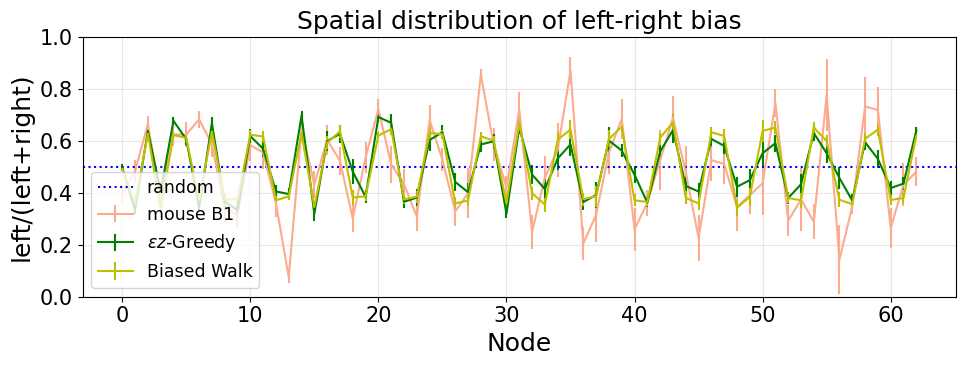

In [141]:
plot_percent_turns(['mouse B1', 'TeAltOptions', 'BiasedWalk4'], filename='nodebias_b1.pdf')

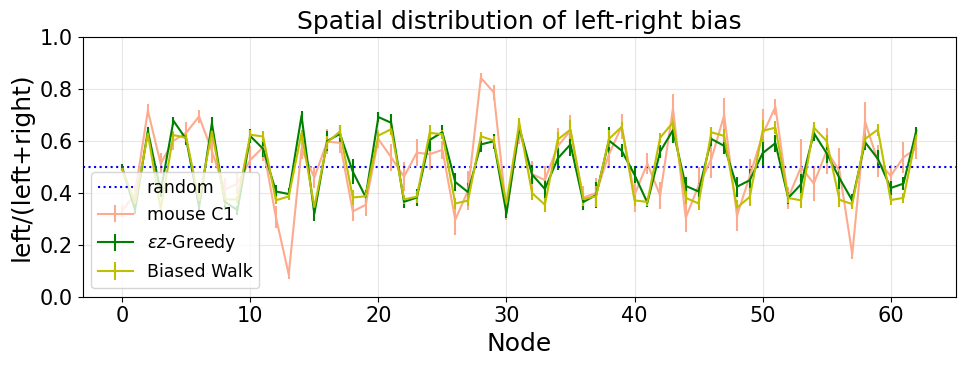

In [142]:
plot_percent_turns(['mouse C1', 'TeAltOptions', 'BiasedWalk4'], filename='nodebias_c1.pdf')